In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.stats import linregress
import lmfit
import copy

plt.ioff()
plt.style.use('bmh')
%config InlineBackend.figure_format = 'svg'

%load_ext watermark

In [2]:
%watermark -v -p numpy,pandas,matplotlib,scipy,lmfit

# CPython 3.6.4
# IPython 6.2.1

# numpy 1.14.0
# pandas 0.22.0
# matplotlib 2.1.2
# scipy 1.0.0
# lmfit 0.9.7

CPython 3.6.4
IPython 6.2.1

numpy 1.14.0
pandas 0.22.0
matplotlib 2.1.2
scipy 1.0.0
lmfit 0.9.7


In [3]:
exp_data1 = pd.read_csv('data_onefilter.txt', delimiter='\t', index_col=False)

time1 = exp_data1['time'].values
concentration1 = exp_data1['concentration'].values
volume1 = exp_data1['volume'].values

Vol = 670  # mL
Vdot1 = linregress(time1, volume1).slope  # mL/s
c_input = 4.94  # mg/mL
c_init = concentration1[0]  # ca. 3 mg/mL
q_init = c_input - c_init  # ca. 2 mg/mL

In [4]:
def rates(state, t, paras):
    c, q = state
    k1, k2, qmax, vol, vdot = paras

    dcdt = vdot / vol * (c_input - c) - k1 * c * (qmax - q) + k2 * q
    dqdt = k1 * c * (qmax - q) - k2 * q
    return [dcdt, dqdt]


def conc(t, c0, q0, k1, k2, qmax, v, vdot):
    initial_state = (c0, q0)
    params_list = [k1, k2, qmax, v, vdot]

    x = odeint(rates, initial_state, t, args=(params_list, ))
    return x


def conc_index(t, c0, q0, k1, k2, qmax, index, v, vdot):
    x = conc(t, c0, q0, k1, k2, qmax, v, vdot)
    return x[:, index]

In [5]:
def rates_twofilters(state, t, paras):
    c1, q1, c2, q2 = state
    k1, k2, qmax, vol, vdot = paras

    dc1dt = vdot / vol * (c_input - c1) - k1 * c1 * (qmax - q1) + k2 * q1
    dq1dt = k1 * c1 * (qmax - q1) - k2 * q1

    dc2dt = vdot / vol * (c1 - c2) - k1 * c2 * (qmax - q2) + k2 * q2
    dq2dt = k1 * c2 * (qmax - q2) - k2 * q2
    return [dc1dt, dq1dt, dc2dt, dq2dt]


def conc_twofilters(t, initial_state, paras):
    x = odeint(rates_twofilters, initial_state, t, args=(paras,))
    return x

In [6]:
c_model = lmfit.Model(conc_index, independent_vars=['t', 'index'])

In [7]:
params = c_model.make_params()

params['k1'].value = 0.1
params['k2'].value = 0
params['qmax'].value = 1
params['c0'].value = c_init
params['q0'].value = q_init
params['v'].value = Vol
params['vdot'].value = Vdot1

params['k1'].vary = True
params['k2'].vary = True
params['qmax'].vary = True
params['c0'].vary = False
params['q0'].vary = False
params['v'].vary = False
params['vdot'].vary = False

In [8]:
lmfit_results1 = c_model.fit(concentration1, params, t=time1, index=0, method='nelder')
print(lmfit_results1.fit_report())

/Users/catullus/miniconda3/envs/pycharm/lib/python3.6/site-packages/scipy/integrate/odepack.py:218: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


[[Model]]
    Model(conc_index)
[[Fit Statistics]]
    # function evals   = 486
    # data points      = 51
    # variables        = 3
    chi-square         = 0.115
    reduced chi-square = 0.002
    Akaike info crit   = -304.831
    Bayesian info crit = -299.035
[[Variables]]
    c0:     3.023799 (fixed)
    q0:     1.916201 (fixed)
    k1:     0.00045604 (init= 0.1)
    k2:     0.00162117 (init= 0)
    qmax:   0.45573885 (init= 1)
    v:      670 (fixed)
    vdot:   0.3784777 (fixed)



Text(0,0.5,'$c$ (mg/mL)')

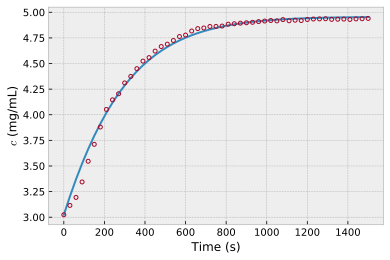

In [9]:
fig, ax = plt.subplots()

ax.plot(time1, lmfit_results1.eval())
ax.plot(time1, concentration1, marker='o', markerfacecolor='None', 
        linestyle='None', markersize=4)
ax.set_xlabel('Time (s)')
ax.set_ylabel(r'$c$ (mg/mL)')

#fig.show()

In [10]:
#q_mass = ( Vol * q_init + 
#          [np.trapz(Vdot1*(c_input-concentration1[0:i+1]), 
#                   x=time1[0:i+1]) for i in range(1,len(exp_data1))] )

In [34]:
protein_loss = ((volume1[1:]-volume1[:-1])*c_input - (volume1[1:]-volume1[:-1])
                 * concentration1[1:])

In [12]:
params2 = copy.deepcopy(params)

params2['k1'].value = 0.01
params2['k2'].value = 0.001
params2['qmax'].value = protein_loss.sum() / Vol

params2['k1'].vary = True
params2['k2'].vary = True
params2['qmax'].vary = False

In [13]:
lmfit_results2 = c_model.fit(concentration1, params2, t=time1, index=0, method='nelder')
print(lmfit_results2.fit_report())

[[Model]]
    Model(conc_index)
[[Fit Statistics]]
    # function evals   = 71
    # data points      = 51
    # variables        = 2
    chi-square         = 0.081
    reduced chi-square = 0.002
    Akaike info crit   = -324.586
    Bayesian info crit = -320.722
[[Variables]]
    c0:     3.023799 (fixed)
    q0:     1.916201 (fixed)
    k1:     0.00092836 (init= 0.01)
    k2:     8.2254e-06 (init= 0.001)
    qmax:   0.28567 (fixed)
    v:      670 (fixed)
    vdot:   0.3784777 (fixed)



Text(0,0.5,'$c$ (mg/mL)')

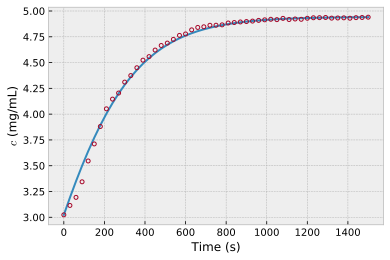

In [14]:
fig, ax = plt.subplots()

ax.plot(time1, lmfit_results2.eval())
ax.plot(time1, concentration1, marker='o', markerfacecolor='None', linestyle='None', markersize=4)
ax.set_xlabel('Time (s)')
ax.set_ylabel(r'$c$ (mg/mL)')

#fig.show()

In [15]:
params3 = copy.deepcopy(params2)

params3['k1'].value = 0.01
params3['k2'].value = 0

params3['k1'].vary = True
params3['k2'].vary = False

In [16]:
lmfit_results3 = c_model.fit(concentration1, params3, t=time1, index=0, method='nelder')
print(lmfit_results3.fit_report())

[[Model]]
    Model(conc_index)
[[Fit Statistics]]
    # function evals   = 29
    # data points      = 51
    # variables        = 1
    chi-square         = 0.081
    reduced chi-square = 0.002
    Akaike info crit   = -326.550
    Bayesian info crit = -324.618
[[Variables]]
    c0:     3.023799 (fixed)
    q0:     1.916201 (fixed)
    k1:     0.00093750 (init= 0.01)
    k2:     0 (fixed)
    qmax:   0.28567 (fixed)
    v:      670 (fixed)
    vdot:   0.3784777 (fixed)



Text(0,0.5,'$c$ (mg/mL)')

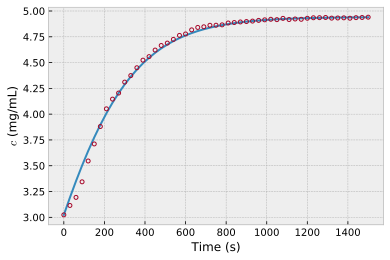

In [17]:
fig, ax = plt.subplots()

ax.plot(time1, lmfit_results3.eval())
ax.plot(time1, concentration1, marker='o', markerfacecolor='None', linestyle='None', markersize=4)
ax.set_xlabel('Time (s)')
ax.set_ylabel(r'$c$ (mg/mL)')

#fig.show()

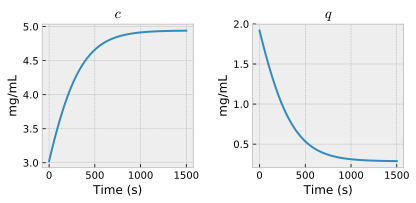

In [18]:
fig, (ax1, ax2) = plt.subplots(1, 2)

ax1.plot(time1, lmfit_results2.eval(index=0))
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('mg/mL')
ax1.set_title(r'$c$')

ax2.plot(time1, c_model.eval(lmfit_results2.params, t=time1, index=1))
ax2.set_xlabel('Time (s)')
ax2.set_ylabel('mg/mL')
ax2.set_title(r'$q$')

fig.set_size_inches(15/2.54, 7.5/2.54)
fig.tight_layout()
#fig.show()

In [19]:
k1_lmfit = lmfit_results3.params['k1'].value
k2_lmfit = lmfit_results3.params['k2'].value
qmax_lmfit = lmfit_results3.params['qmax'].value

In [20]:
Vdot_fill = 670 / 16  # 41.875 mL/s

v_sim = np.arange(0, 670, 1)
t_sim = v_sim / Vdot_fill

fill = c_model.eval(lmfit_results3.params, vdot=Vdot_fill, t=t_sim, index=[0,1])

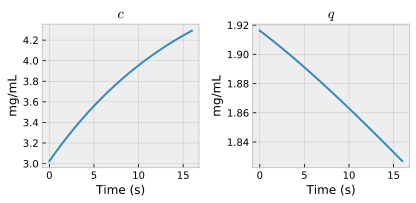

In [21]:
fig, (ax1, ax2) = plt.subplots(1, 2)

ax1.plot(t_sim, fill[:, 0])
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('mg/mL')
ax1.set_title(r'$c$')

ax2.plot(t_sim, fill[:, 1])
ax2.set_xlabel('Time (s)')
ax2.set_ylabel('mg/mL')
ax2.set_title(r'$q$')

fig.set_size_inches(15/2.54, 7.5/2.54)
fig.tight_layout()
#fig.show()

In [22]:
avg_fill = (np.trapz(Vdot_fill * fill[:,0],x=t_sim) /
            np.trapz(np.repeat(Vdot_fill, len(t_sim)), x=t_sim))

In [23]:
avg_fill

3.759579873320604

In [24]:
t_hold = np.arange(0,300,1)

In [25]:
hold1 = c_model.eval(lmfit_results3.params, c0=fill[-1,0], q0=fill[-1,1], 
                     vdot=0, t=t_hold, index=[0,1])

In [26]:
hold2 = c_model.eval(lmfit_results3.params, c0=avg_fill, q0=0, 
                     vdot=0, t=t_hold, index=[0,1])

In [27]:
init_state = hold1[-1,0], hold1[-1,1], hold2[-1,0], hold2[-1,1]

In [28]:
exp_data2 = pd.read_csv('data_twofilters.txt', delimiter='\t', index_col=False)
time2 = exp_data2['time'].values
concentration2 = exp_data2['concentration'].values
volume2 = exp_data2['volume'].values

Vdot2 = linregress(time2, volume2).slope

In [29]:
twofilters = conc_twofilters(time2, init_state, [k1_lmfit, k2_lmfit, qmax_lmfit, Vol, Vdot2])

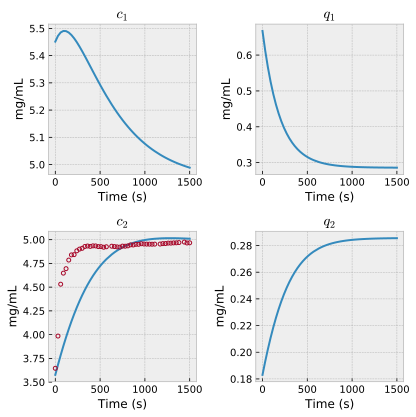

In [30]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)

ax1.plot(time2, twofilters[:,0])
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('mg/mL')
ax1.set_title(r'$c_1$')

ax2.plot(time2, twofilters[:,1])
ax2.set_xlabel('Time (s)')
ax2.set_ylabel('mg/mL')
ax2.set_title(r'$q_1$')

ax3.plot(time2, twofilters[:,2])
ax3.plot(time2, concentration2, marker='o', markerfacecolor='None', 
         linestyle='None', markersize=4)
ax3.set_xlabel('Time (s)')
ax3.set_ylabel('mg/mL')
ax3.set_title(r'$c_2$')

ax4.plot(time2, twofilters[:,3])
ax4.set_xlabel('Time (s)')
ax4.set_ylabel('mg/mL')
ax4.set_title(r'$q_2$')

fig.set_size_inches(15/2.54, 15/2.54)
fig.tight_layout()
#fig.show()

In [35]:
hold0 = c_model.eval(lmfit_results3.params, c0=c_input, q0=0, 
                     vdot=0, t=t_hold, index=[0,1])

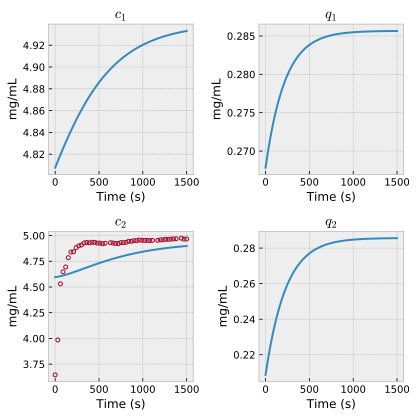

In [36]:
Vdot_fill = 670 / 16  # 41.875 mL/s

v_sim = np.arange(0, 670, 1)
t_sim = v_sim / Vdot_fill

fill = c_model.eval(lmfit_results3.params, vdot=Vdot_fill, c0=hold0[-1,0], 
                    q0=hold0[-1,1], t=t_sim, index=[0,1])

avg_fill = (np.trapz(Vdot_fill * fill[:,0],x=t_sim) /
            np.trapz(np.repeat(Vdot_fill, len(t_sim)), x=t_sim))

t_hold = np.arange(0,300,1)

hold1 = c_model.eval(lmfit_results3.params, c0=fill[-1,0], q0=fill[-1,1], 
                     vdot=0, t=t_hold, index=[0,1])

hold2 = c_model.eval(lmfit_results3.params, c0=avg_fill, q0=0, 
                     vdot=0, t=t_hold, index=[0,1])

init_state = hold1[-1,0], hold1[-1,1], hold2[-1,0], hold2[-1,1]

exp_data2 = pd.read_csv('data_twofilters.txt', delimiter='\t', index_col=False)
time2 = exp_data2['time'].values
concentration2 = exp_data2['concentration'].values
volume2 = exp_data2['volume'].values

Vdot2 = linregress(time2, volume2).slope

twofilters = conc_twofilters(time2, init_state, 
                             [k1_lmfit, k2_lmfit, qmax_lmfit, Vol, Vdot2])

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)

ax1.plot(time2, twofilters[:,0])
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('mg/mL')
ax1.set_title(r'$c_1$')

ax2.plot(time2, twofilters[:,1])
ax2.set_xlabel('Time (s)')
ax2.set_ylabel('mg/mL')
ax2.set_title(r'$q_1$')

ax3.plot(time2, twofilters[:,2])
ax3.plot(time2, concentration2, marker='o', markerfacecolor='None', 
         linestyle='None', markersize=4)
ax3.set_xlabel('Time (s)')
ax3.set_ylabel('mg/mL')
ax3.set_title(r'$c_2$')

ax4.plot(time2, twofilters[:,3])
ax4.set_xlabel('Time (s)')
ax4.set_ylabel('mg/mL')
ax4.set_title(r'$q_2$')

fig.set_size_inches(15/2.54, 15/2.54)
fig.tight_layout()
#fig.show()

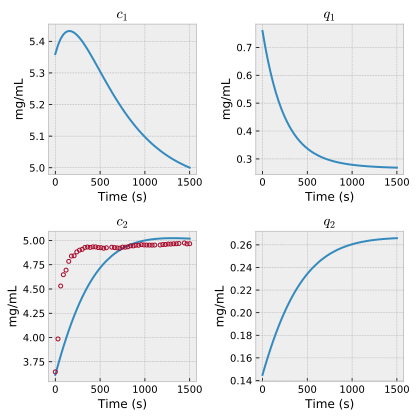

In [38]:
Vdot_fill = 670 / 16  # 41.875 mL/s

v_sim = np.arange(0, 670, 1)
t_sim = v_sim / Vdot_fill

fill = c_model.eval(lmfit_results1.params, vdot=Vdot_fill, c0=c_init, 
                    q0=q_init, t=t_sim, index=[0,1])

avg_fill = (np.trapz(Vdot_fill * fill[:,0],x=t_sim) /
            np.trapz(np.repeat(Vdot_fill, len(t_sim)), x=t_sim))

t_hold = np.arange(0,300,1)

hold1 = c_model.eval(lmfit_results1.params, c0=fill[-1,0], q0=fill[-1,1], 
                     vdot=0, t=t_hold, index=[0,1])

hold2 = c_model.eval(lmfit_results1.params, c0=avg_fill, q0=0, 
                     vdot=0, t=t_hold, index=[0,1])

init_state = hold1[-1,0], hold1[-1,1], hold2[-1,0], hold2[-1,1]

exp_data2 = pd.read_csv('data_twofilters.txt', delimiter='\t', index_col=False)
time2 = exp_data2['time'].values
concentration2 = exp_data2['concentration'].values
volume2 = exp_data2['volume'].values

Vdot2 = linregress(time2, volume2).slope

k1_lmfit = lmfit_results1.params['k1'].value
k2_lmfit = lmfit_results1.params['k2'].value
qmax_lmfit = lmfit_results1.params['qmax'].value

twofilters = conc_twofilters(time2, init_state, 
                             [k1_lmfit, k2_lmfit, qmax_lmfit, Vol, Vdot2])

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)

ax1.plot(time2, twofilters[:,0])
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('mg/mL')
ax1.set_title(r'$c_1$')

ax2.plot(time2, twofilters[:,1])
ax2.set_xlabel('Time (s)')
ax2.set_ylabel('mg/mL')
ax2.set_title(r'$q_1$')

ax3.plot(time2, twofilters[:,2])
ax3.plot(time2, concentration2, marker='o', markerfacecolor='None', 
         linestyle='None', markersize=4)
ax3.set_xlabel('Time (s)')
ax3.set_ylabel('mg/mL')
ax3.set_title(r'$c_2$')

ax4.plot(time2, twofilters[:,3])
ax4.set_xlabel('Time (s)')
ax4.set_ylabel('mg/mL')
ax4.set_title(r'$q_2$')

fig.set_size_inches(15/2.54, 15/2.54)
fig.tight_layout()
#fig.show()